### Import libraries

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inspect
import pickle

### Load data

In [2]:
print(sum(metadata['number_of_nn_within_radius']) / len(metadata['number_of_nn_within_radius']))

NameError: name 'metadata' is not defined

### Scheduler Graphs

In [101]:
db_size = 10 ** 5
domain = 10 ** 7

input_dir = f'graphs/schedulers/scheduler_1.6/size_{db_size}_domain_{domain}/'
output_dir = f'graphs/schedulers/inverse/'
raw_df = pd.read_csv(f'{input_dir}raw.csv')

with open(f'{input_dir}metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

In [102]:
raw_df = raw_df[raw_df['scheduler_type'].isin(['constant', 'inverse_sqrt', 'inverse_linear', 'inverse_quadratic'])]

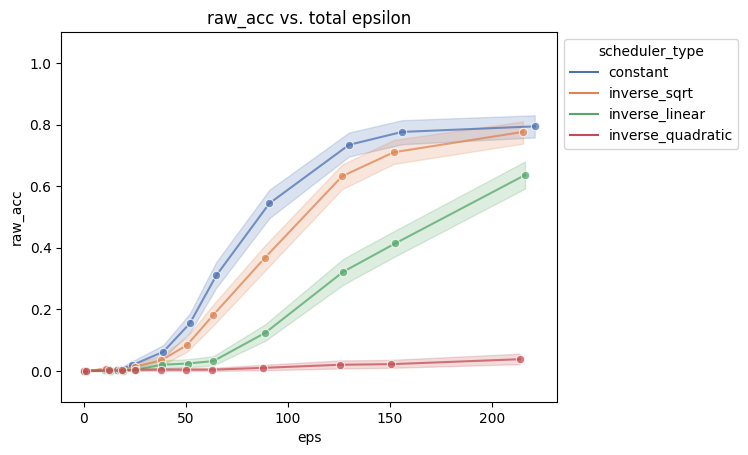

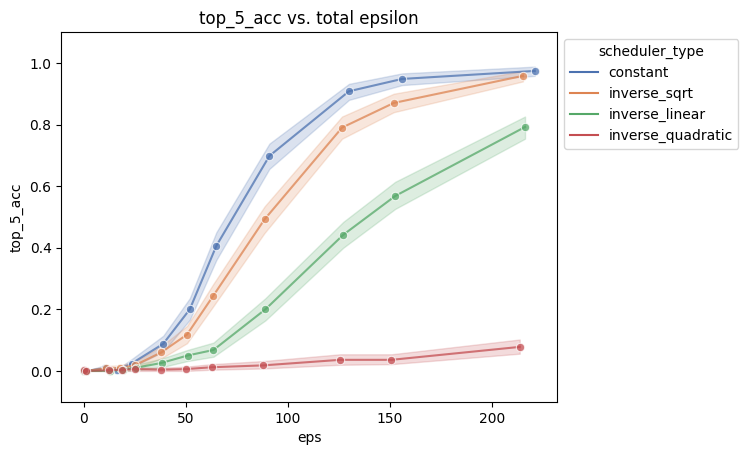

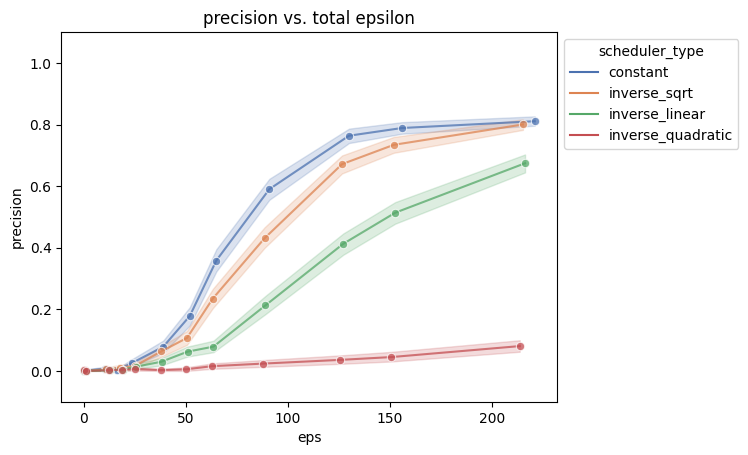

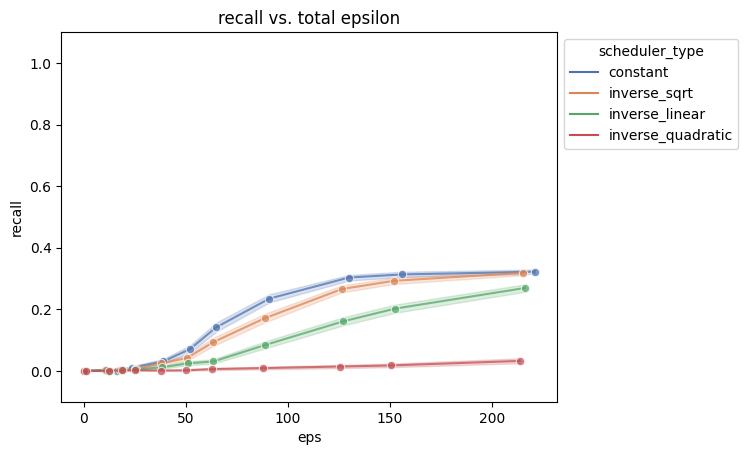

In [103]:
for metric in ['raw_acc', 'top_5_acc', 'precision', 'recall']: # precision and recall considers top K values relevant

    # plot for both DP-TT and LDP
    plot = sns.lineplot(
        data=raw_df, x='eps', y=f'{metric}', 
        hue='scheduler_type',
        palette='deep', alpha=0.75, marker='o',
    )

    # graph params
    plot.set(
        ylim=(-0.1, 1.1),
        title=f'{metric} vs. total epsilon'
    )

    # move legend
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    
    plt.show()

    # save plot
    plot.get_figure().savefig(f'{output_dir}{metric}.png', bbox_inches='tight', dpi=400)
    plot.get_figure().clf()

### Density graphs

In [57]:
db_size = 10 ** 3
domain = 10 ** 7

output_dir = f'graphs/densities/size_{db_size}_domain_{domain}/'
raw_df = pd.read_csv(f'{output_dir}raw.csv')

with open(f'{output_dir}metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

In [58]:
print(sum(metadata['number_of_nn_within_radius']) / len(metadata['number_of_nn_within_radius']))

28.372


In [38]:
# raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE-GEO'])]
raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE', 'L-SRR'])]

In [39]:
with pd.option_context('display.max_rows', None):
    print(raw_df[raw_df['early_stopping_level'] == 1]['eps'].value_counts())

eps
0.058895      1452
0.600195      1434
70.000000     1425
11.544233     1422
16.498686     1422
170.000000    1422
120.000000    1419
100.000000    1416
7.109986      1413
50.000000     1413
40.000000     1401
27.705966     1374
25.793700      126
36.000000       99
45.000000       87
6.685097        87
90.000000       84
108.000000      81
153.000000      78
15.421038       78
10.818975       78
63.000000       75
0.568787        66
0.055866        48
Name: count, dtype: int64


In [40]:
frequent_values_index = raw_df['eps'].value_counts()[raw_df['eps'].value_counts() > 750].index

In [41]:
raw_df = raw_df[raw_df['eps'].isin(frequent_values_index)]

In [42]:
# change early_stopping_level to return_size
for early_stopping_level in [1, 3, 5, 9]:
    raw_df.loc[raw_df['early_stopping_level'] == early_stopping_level, 'return_size'] = raw_df[raw_df['early_stopping_level'] == early_stopping_level]['return_size'].mean()

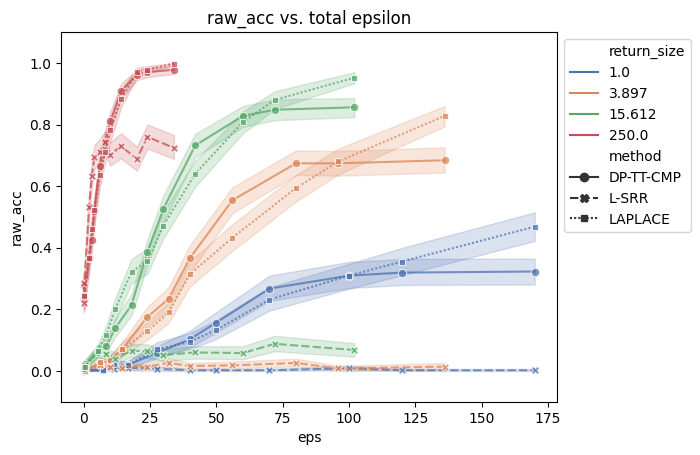

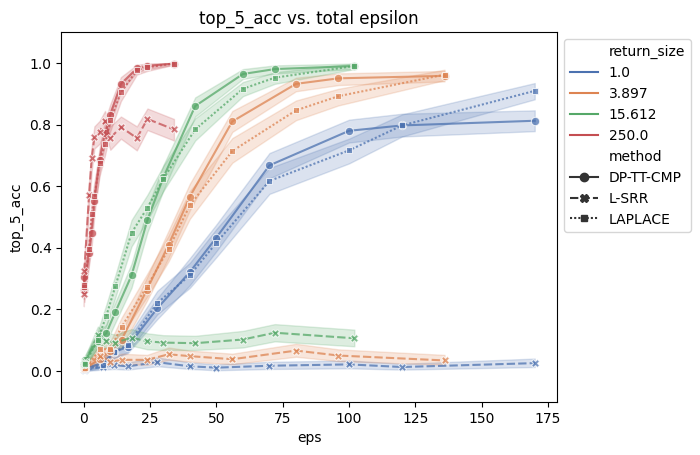

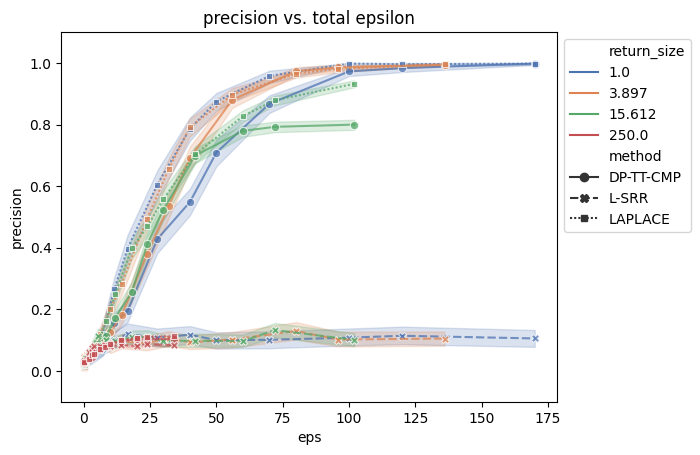

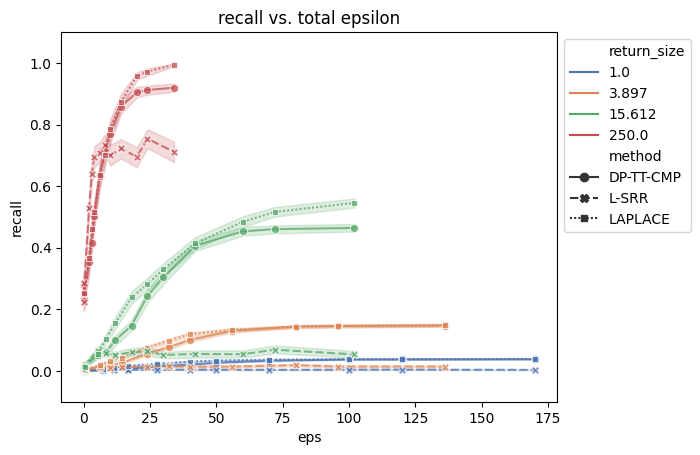

In [43]:
for metric in ['raw_acc', 'top_5_acc', 'precision', 'recall']: # precision and recall considers top K values relevant

    # plot for both DP-TT and LDP
    plot = sns.lineplot(
        data=raw_df, x='eps', y=f'{metric}', 
        hue='return_size', style='method', markers=True,
        palette='deep', alpha=0.75,
    )

    # graph params
    plot.set(
        ylim=(-0.1, 1.1),
#         xlim=(0, 10),
        title=f'{metric} vs. total epsilon'
    )

    # move legend
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    
    plt.show()

    # save plot
    plot.get_figure().savefig(f'{output_dir}{metric}.png', bbox_inches='tight', dpi=400)
    plot.get_figure().clf()

### DIS Exploration

In [190]:
db_size = 10 ** 4
domain = 10 ** 7

output_dir = f'graphs/densities/size_{db_size}_domain_{domain}/'
raw_df = pd.read_csv(f'{output_dir}raw.csv')

with open(f'{output_dir}metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

In [191]:
raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE-GEO'])]
# raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE', 'L-SRR'])]

In [192]:
for early_stopping_level in [1, 3, 5, 9]:
    raw_df.loc[raw_df['early_stopping_level'] == early_stopping_level, 'return_size'] = raw_df[raw_df['early_stopping_level'] == early_stopping_level]['return_size'].mean()

In [195]:
raw_df['geo_eps'] = (raw_df['geo_eps'] / 500).round().astype(int) * 500

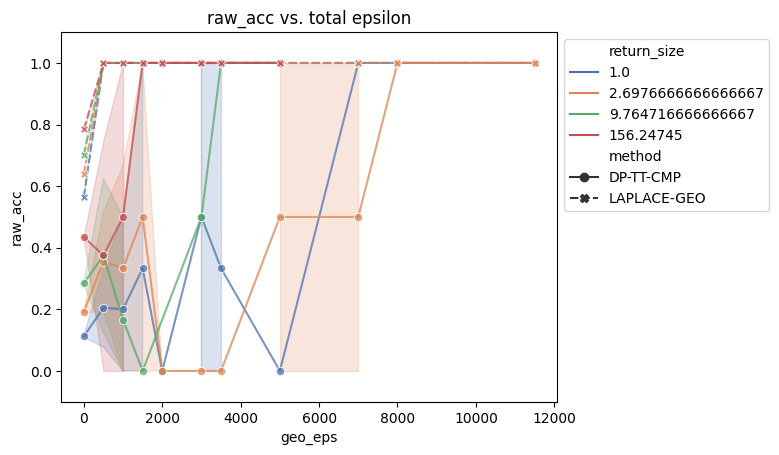

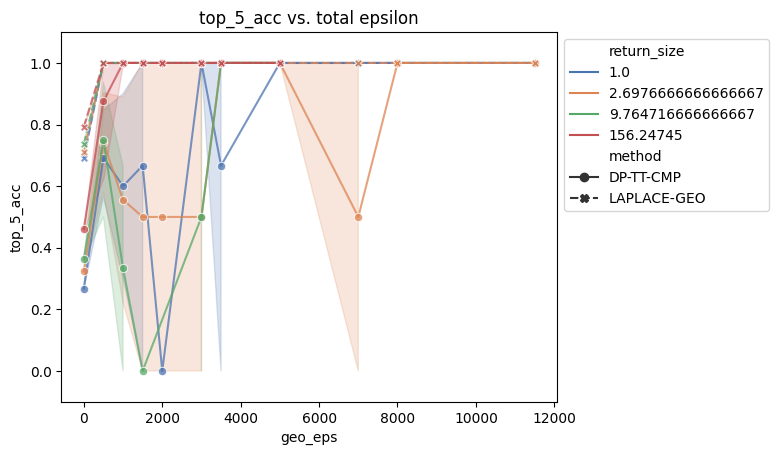

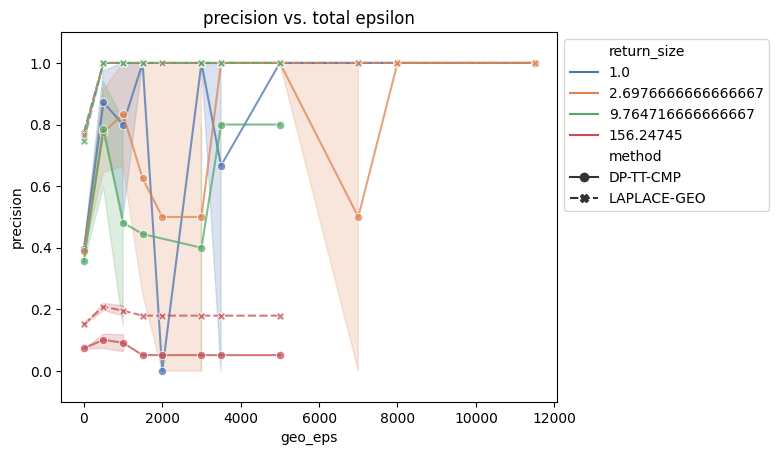

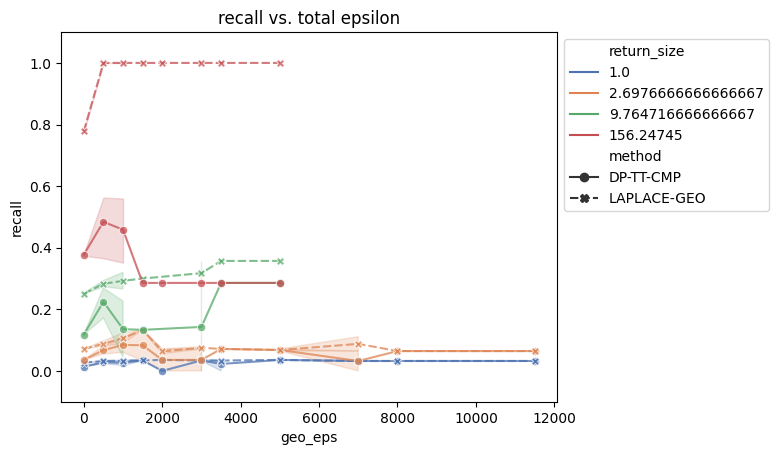

In [196]:
for metric in ['raw_acc', 'top_5_acc', 'precision', 'recall']: # precision and recall considers top K values relevant

    # plot for both DP-TT and LDP
    plot = sns.lineplot(
        data=raw_df, x='geo_eps', y=f'{metric}', 
        hue='return_size', style='method', markers=True,
        palette='deep', alpha=0.75,
    )

    # graph params
    plot.set(
        ylim=(-0.1, 1.1),
#         xlim=(0, 10),
        title=f'{metric} vs. total epsilon'
    )

    # move legend
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    
    plt.show()

    # save plot
    plot.get_figure().savefig(f'{output_dir}{metric}_dis.png', bbox_inches='tight', dpi=400)
    plot.get_figure().clf()

## Gowalla

In [46]:
import pandas as pd

df = pd.read_csv('./data/loc-gowalla_totalCheckins.txt', sep='\t', header=None)
df.columns = ['userid','timestamp','latitude','longitude','spotid']

In [26]:
df.size

32214460

In [27]:
df = df.drop_duplicates(subset=['userid'])

In [54]:
df.size

12885784

In [53]:
df = df[['latitude', 'longitude']]

In [55]:
lat_min, lat_max = (37.5395, 37.7910)
lon_min, lon_max = (-122.5153, -122.3789)
nyc_events = df[(df['longitude']>lon_min) & 
           (df['longitude']<lon_max) & 
           (df['latitude']>lat_min) & 
           (df['latitude']<lat_max)]

In [50]:
nyc_events.size

268474

In [51]:
server = list(nyc_events.itertuples(index=False, name=None))

In [52]:
len(server)

134237